# Time Series Analysis: Tutorial 8

## Import packages

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rc('text', usetex=True)
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from sklearn.linear_model import LinearRegression
from scipy.stats import bernoulli

## Exercise 1: Non-stationarity

Random Walk: 

$X_t=x+\sum_{i=1}^{t}Y_i$ with $x\in\mathbb{R}$  and $Y_i \overset{i.i.d.}{\sim} Rad(1/2)$

Here: $x=0$

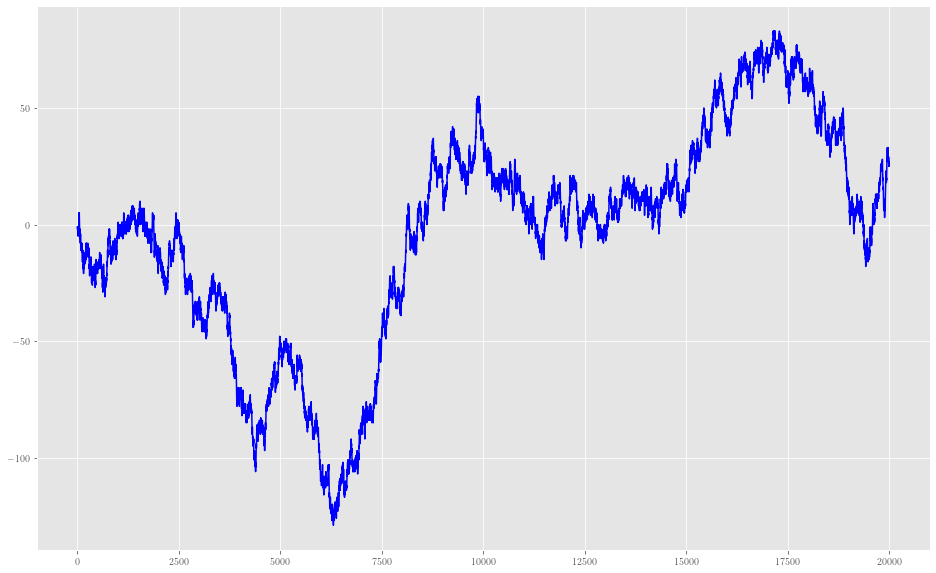

In [12]:
# Simulate a random walk
rw = bernoulli.rvs(0.5, size=20000)
rw[rw == 0] = -1
rw_cum = rw.cumsum()
# Plot the random walk
fig = plt.figure(figsize=(16,10))
fig = plt.plot(rw_cum, color = 'blue')

# Exercise 2: TS-model Estimation

Trend-stationary (TS) Model:		


$y_t=\sum_{j=0}^{m}{\delta_jt^j}+u_t$ with $u_t~ARMA(p,q)$

Here: $y_t=\delta_0 + \delta_1*t+u_t$

- Assume the linear trend
- Inspect the residuals, are they stationary?
- Which ARMA model could model the dependency in the residuals?

## Load and inspect the data

In [13]:
# Load the data
series=pd.read_stata('C:/Users/MS/Documents/TU/Teaching/TSA/B-Computations/GNPperCapita.dta')
# Calculate first differences
series['relGNP'] = 100*series.GNP.pct_change()
# inspect the data
print(series)

          time    GNP      lnGNP    relGNP
0   1947-01-01  12447   9.429235       NaN
1   1947-04-01  12375   9.423433 -0.578453
2   1947-07-01  12309   9.418086 -0.533333
3   1947-10-01  12440   9.428673  1.064262
4   1948-01-01  12589   9.440578  1.197749
..         ...    ...        ...       ...
250 2009-07-01  42278  10.652022  0.418032
251 2009-10-01  42688  10.661674  0.969772
252 2010-01-01  43067  10.670512  0.887837
253 2010-04-01  43176  10.673040  0.253094
254 2010-07-01  43323  10.676439  0.340467

[255 rows x 4 columns]


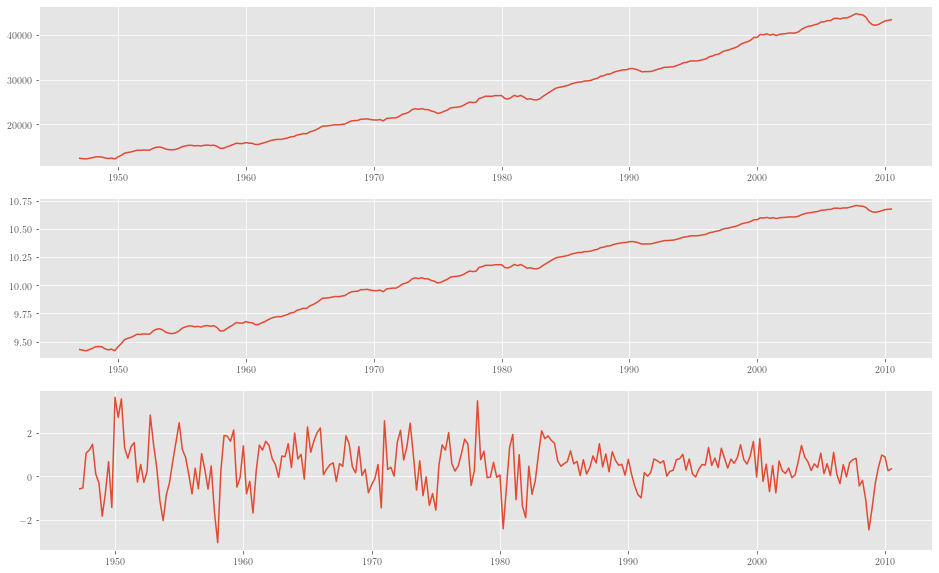

In [14]:
# Plot the series
fig, ax=plt.subplots(3,1,figsize=(16,10))
ax[0].plot(series['time'],series['GNP'])
ax[1].plot(series['time'],series['lnGNP'])
ax[2].plot(series['time'],series['relGNP'])

## Stationarity of the ln(GNP) series 

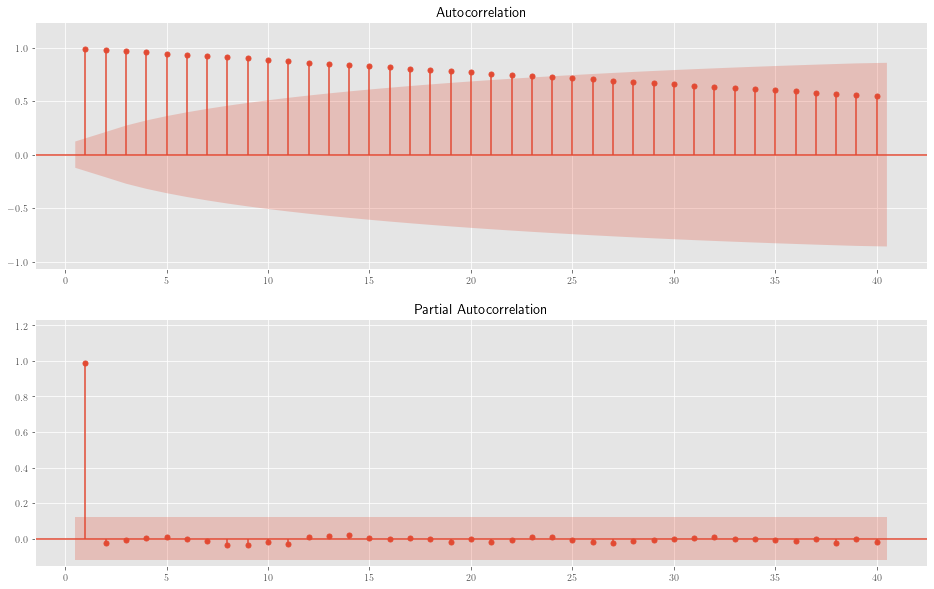

In [15]:
# We continue to look at the "middle" time series, i.e. the logarithm of the real GNP in the U.S.
# Is this data stationary? 
# Let's investigate on the serial dependency pattern:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series['lnGNP'].values[1:], lags=40, ax=ax1, alpha=0.05, zero=False, auto_ylims=True)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series['lnGNP'].values[1:], lags=40, ax=ax2, alpha=0.05, zero=False, auto_ylims=True, method = 'ywm')

Comments: 

- There is excessive autocorrelation in the time series, i.e. it does not appear to be stationary.
- See the oartial autocorrelation coefficient estimate: it is equal to one!
- To nonetheless model the behaviour, we now assume the TS-model with a linear trend and try to fit it to the data.

## Modelling the Time Series, using the TS-model

### 1. Fitting a linear Trend to the GNP series

In [16]:
# Estimate the trend, assuming that it is linear
# Simple estimation by OLS
series['t'] = pd.Series(range(0,255))
result = smm.ols(formula="lnGNP ~ t", data=series).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  lnGNP   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 2.866e+04
Date:                Tue, 17 Jan 2023   Prob (F-statistic):          2.30e-262
Time:                        11:53:50   Log-Likelihood:                 483.18
No. Observations:                 255   AIC:                            -962.4
Df Residuals:                     253   BIC:                            -955.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.4408      0.005   2069.977      0.0

What can we conclude from the model output?

$y_t=\sum_{j=0}^m \delta_j t^j+u_t$ with $u_t \sim ARMA(p,q)$

I.e. $\hat{y}_t = 9.440 + 0.0053 t + \hat{u}_t$

### 2. Are the resulting residuals stationary?

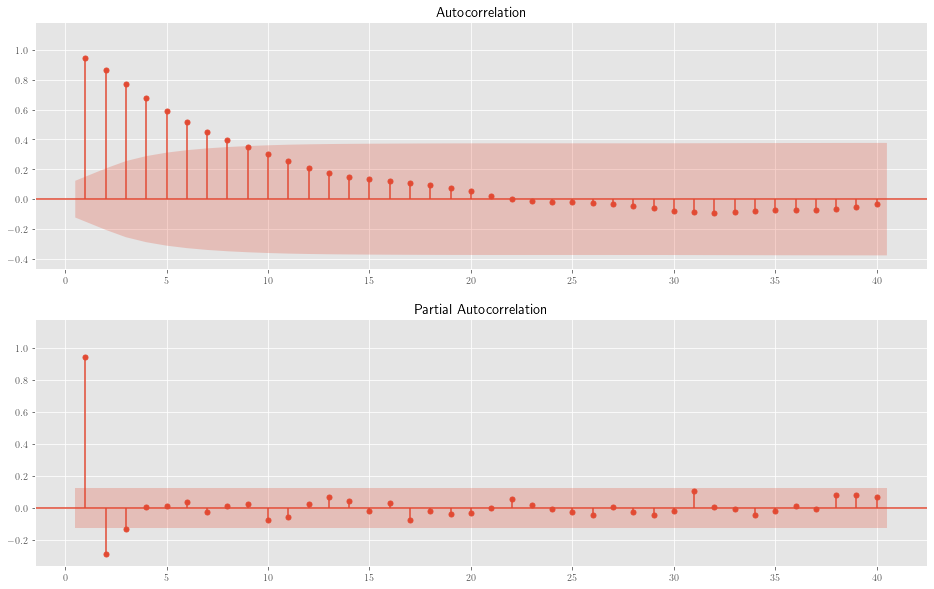

In [17]:
# ACF of the residuals
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(result.resid.values[1:], lags=40, ax=ax1, alpha=0.05, zero=False, auto_ylims=True)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(result.resid.values[1:], lags=40, ax=ax2, alpha=0.05, zero=False, auto_ylims=True, method = 'ywm')

Comment: The residuals appear to be stationary, autocorrelation eventually fades out.

Inspection of the PACF indicates that an AR(3) (i.e. ARMA(3,0)) process could model the stationary part of the series.

### 3. Estimation of the Stationary part of the Series

In [18]:
# Estimate the stationary part of the series using an AR(3)
# Use the ARIMA command, the AR(3) is the ARIMA(3,0,0)
AR3 =ARIMA(result.resid.values[1:],order=(3,0,0))
AR3_fit = AR3.fit()
print(AR3_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  254
Model:                 ARIMA(3, 0, 0)   Log Likelihood                 833.548
Date:                Tue, 17 Jan 2023   AIC                          -1657.096
Time:                        11:53:55   BIC                          -1639.409
Sample:                             0   HQIC                         -1649.980
                                - 254                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0037      0.011     -0.326      0.744      -0.026       0.018
ar.L1          1.2979      0.051     25.403      0.000       1.198       1.398
ar.L2         -0.2095      0.086     -2.442      0.0

Comments:
- All model parameters are significant
- AR(3) seems to do a reasonably good job

The estimated equation for the stationary part of the TS-model writes: $\hat{u}_t=1.2979 u_{t-1} - 0.2095 u_{t-2} - 0.1418 u_{t-3}$

### 4. Is there still correlation left? 

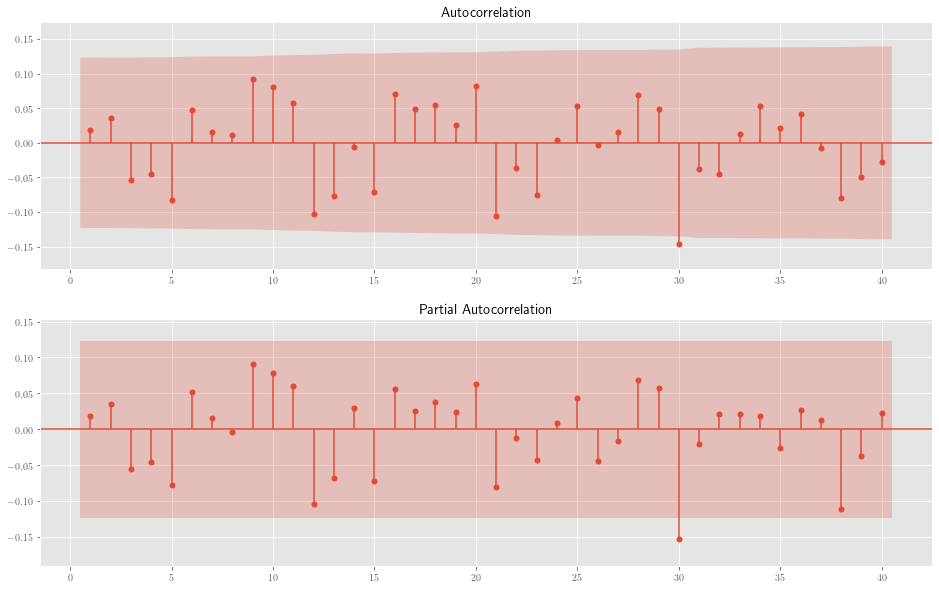

In [19]:
# ACF of the residuals
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(AR3_fit.resid, lags=40, ax=ax1, alpha=0.05, zero=False, auto_ylims=True)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(AR3_fit.resid, lags=40, ax=ax2, alpha=0.05, zero=False, auto_ylims=True, method = 'ywm')

Comments:
- There seems to be no correlation left
- We can check for correlation of the residuals (in fact, any time series), by using the Ljung–Box test.
- In the test we sum up the suqared correlation coefficients, which should be zero on average (this is our NULL) and normally distributed. We therefore know that under the Null they are $\chi^2$ distributed.

We have as our Null-hypothesis: 

$H_0$: All autocorrelation coefficients are zero

- If we reject the Null we know that there is some autocorrelation left in the residuals. 

The test-statistic writes:

$Q=T(T+2)\sum_{k=1}^K \frac{1}{T-k} \hat{\rho}_k^2 \sim \chi^2$ with $K-p-q$ degrees of freedom. 

In [22]:
# Box-Ljung Test 
BLtest = sm.stats.acorr_ljungbox(AR3_fit.resid, lags = 30, return_df=True)
print(BLtest)

      lb_stat  lb_pvalue
1    0.092407   0.761140
2    0.412269   0.813723
3    1.164506   0.761529
4    1.704275   0.789941
5    3.472955   0.627484
6    4.076090   0.666380
7    4.143691   0.763086
8    4.174873   0.841011
9    6.464863   0.692641
10   8.171697   0.612070
11   9.079791   0.614527
12  11.958493   0.449019
13  13.561859   0.405407
14  13.571226   0.482118
15  14.951951   0.454884
16  16.301282   0.432139
17  16.956322   0.457329
18  17.792329   0.469410
19  17.970116   0.524435
20  19.871656   0.465984
21  22.951810   0.346553
22  23.314079   0.384180
23  24.928217   0.353997
24  24.931505   0.409491
25  25.751445   0.420956
26  25.753587   0.476712
27  25.821080   0.528547
28  27.185722   0.508152
29  27.881183   0.524273
30  34.095938   0.277014


Comments: 
- Look at the lb_pvalue column
- All the pvalues are insignificant, i.e. the observed Q values are very much compatible with the hypotheses that there is no correlation left in the residuals at any of the first 30 lags. This is what we would like to see. 